In [1]:
import pandas as pd
from IPython.display import display, Markdown, Math
from sympy import symbols, Eq, sqrt, Sum, diff, Indexed,IndexedBase, Idx, Sum, Function, solve, solveset, S
from sympy.abc import i
import math
from scipy.stats import lognorm, norm
from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Example 4.1: Reliability Assessment Using a Nonlinear Performance Function

In [2]:
X = IndexedBase('X')
i = symbols('i', cls=Idx)
Z = lambda X_1, X_2, X_3: X_1 * X_2 - sqrt(X_3)
Z_fn = lambda X_1, X_2, X_3: X_1 * X_2 - np.sqrt(X_3)
Z_exp = Z(X[1], X[2], X[3])
# Z_eqn = Eq(Z, Z_exp)

In [3]:
XVals = pd.DataFrame([
  [1, 0.25, 0.25],
  [5, 0.25, 0.05],
  [4, 0.80, 0.20]
], index=[X[1],X[2],X[3]], columns=['mean', 'std_dev', 'cov'])
XVals['dZ_dX'] = {x:diff(Z_exp, x) for x in XVals.index}
XVals

,mean,std_dev,cov,dZ_dX
X[1],1,0.25,0.25,X[2]
X[2],5,0.25,0.05,X[1]
X[3],4,0.80,0.20,-1/(2*sqrt(X[3]))


In [4]:
mu_Z = Z_exp.evalf(subs=XVals['mean'].to_dict())
display(Math(rf"\mu_Z\approx{mu_Z}"))

<IPython.core.display.Math object>

In [5]:
def uncorrelated_variance(X):
  return math.sqrt(
    sum([
      (row['std_dev'] ** 2) * row['dZ_dX'].evalf(subs=X['mean'].to_dict()) ** 2 for x, row in X.iterrows()
    ])
  )
sigma_Z = uncorrelated_variance(XVals)
display(Math(rf"\sigma_Z\approx{sigma_Z}"))

<IPython.core.display.Math object>

In [6]:
beta_Z = mu_Z / sigma_Z
display(Math(rf"\beta_i={beta_Z}"))

<IPython.core.display.Math object>

## Case (a)

In [7]:
xs = IndexedBase('x^*')
mu = IndexedBase('mu')
alpha = IndexedBase('alpha')
beta = IndexedBase('beta', real=True)
sigma = IndexedBase('sigma')
xs_fn = lambda i, mu, alpha, beta, std_dev : mu[i] - alpha[i] * beta * std_dev[i]

XIter = XVals.copy()
XIter['failure_point'] = XIter['mean']

for iter_n in range(3):
  XIter['dZ_dX-std_dev'] = XVals['dZ_dX'].apply(lambda dZ_dX : dZ_dX.evalf(subs=XIter['failure_point'].to_dict())) * XIter['std_dev']
  XIter['dir_cos'] = XIter['dZ_dX-std_dev'] / math.sqrt((XIter['dZ_dX-std_dev']**2).sum())
  display(Markdown(f"### Case (a) Iteration " + str(iter_n + 1)))
  display(XIter[['failure_point', 'dZ_dX-std_dev', 'dir_cos']])

  Z_eqn_tosolve = Z(*[
    xs_fn(i, mu, alpha, beta, sigma).n(subs=XIter.loc[X[i]].rename({
      'mean': mu[i],
      'std_dev': sigma[i],
      'dir_cos': alpha[i]
    }).to_dict()) for i in range(1,4)
  ])
  
  beta_Z_set = solveset(Z_eqn_tosolve, beta, domain=S.Reals)
  beta_Z = min(beta_Z_set)
  display(Math(rf'\beta_{iter_n+1}={beta_Z}'))

  XIter['failure_point'] = {
    X[i]: xs_fn(i, mu, alpha, beta_Z, sigma).n(subs=XIter.loc[X[i]].rename({
      'mean': mu[i],
      'std_dev': sigma[i],
      'dir_cos': alpha[i]
    }).to_dict())
    for i in range(1,4)
  }

XIter['safety_factor'] = XIter['failure_point'] / XIter['mean']
XIter[['failure_point', 'safety_factor']]

### Case (a) Iteration 1

,failure_point,dZ_dX-std_dev,dir_cos
X[1],1,1.25000000000000,0.968730322865161
X[2],5,0.250000000000000,0.193746064573032
X[3],4,-0.200000000000000,-0.154996851658426


<IPython.core.display.Math object>

### Case (a) Iteration 2

,failure_point,dZ_dX-std_dev,dir_cos
X[1],0.424247732660099,1.22121238663300,0.984124661473408
X[2],4.88484954653202,0.106061933165025,0.0854709346332666
X[3],4.29478516087803,-0.193014203679351,-0.155542180815256


<IPython.core.display.Math object>

### Case (a) Iteration 3

,failure_point,dZ_dX-std_dev,dir_cos
X[1],0.418667784835675,1.23737786743192,0.984616783402718
X[2],4.94951146972770,0.104666946208919,0.0832864677939463
X[3],4.29401699704002,-0.193031467223170,-0.153600631913065


<IPython.core.display.Math object>

,failure_point,safety_factor
X[1],0.418379673649118,0.418379673649118
X[2],4.95080207508598,0.990160415017197
X[3],4.29034564892055,1.07258641223014


## Case (b)

The following are from A.66, 4.17b & 4.18c  

In [8]:
s_y = lambda m_x, s_x : np.sqrt(np.log( 1 + (s_x / m_x) ** 2 ) )
m_y = lambda m_x, s_x : np.log( m_x ) - 0.5 * s_y(m_x, s_x) ** 2
s_x = lambda m_y, s_y : (m_x(m_y, s_y) ** 2) * (np.exp(s_y**2)-1)
m_x = lambda m_y, s_y : np.exp(m_y + 0.5 * s_y ** 2)

eq_norm_std = lambda x, m_y, s_y : x * s_y
eq_norm_mean = lambda x, m_y, s_y : x - ((np.log(x) - m_y) / s_y)* eq_norm_std(x, m_y, s_y)

In [9]:

xs = IndexedBase('x^*')
mu = IndexedBase('mu')
alpha = IndexedBase('alpha')
beta = IndexedBase('beta', real=True)
sigma = IndexedBase('sigma')
xs_fn = lambda i, mu, alpha, beta, std_dev : mu[i] - alpha[i] * beta * std_dev[i]

XIter = XVals.copy()

XIter['m_y'] = m_y(XIter['mean'], XIter['std_dev'])
XIter['s_y'] = s_y(XIter['mean'], XIter['std_dev'])
XIter['lognorm_dist'] = [ lognorm(scale=math.exp(r.m_y), s=r.s_y) for x_i, r in XIter.iterrows()]
XIter['failure_point'] = XIter['mean']

def symbolizeX(XIter, i):
  return XIter[['eq_norm_mean', 'eq_norm_std', 'dir_cos']].rename({
    'eq_norm_mean': mu[i],
    'eq_norm_std': sigma[i],
    'dir_cos': alpha[i]
  })

iterations = 5
for iter_n in range(iterations):
  XIter['eq_norm_mean'] = eq_norm_mean(XIter['failure_point'], XIter['m_y'],XIter['s_y'])
  XIter['eq_norm_std'] = eq_norm_std(XIter['failure_point'], XIter['m_y'],XIter['s_y'])
  XIter['dZ_dX-std_dev'] = XVals['dZ_dX'].apply(lambda dZ_dX : dZ_dX.evalf(subs=XIter['failure_point'].to_dict())) * XIter['eq_norm_std']
  XIter['dir_cos'] = XIter['dZ_dX-std_dev'] / math.sqrt((XIter['dZ_dX-std_dev']**2).sum())
  display(Markdown(f"## Iteration " + str(iter_n + 1)))
  display(XIter)

  Z_eqn_tosolve = Z(*[
    xs_fn(i, mu, alpha, beta, sigma).n(subs=symbolizeX(XIter.loc[X[i]], i).to_dict()) for i in range(1,4)
  ])
  beta_Z_set = solveset(Z_eqn_tosolve, beta, domain=S.Reals)
  beta_Z = min(beta_Z_set)
  display(Math(rf'\beta_{iter_n+1}={beta_Z}'))

  XIter['failure_point'] = {
    X[i]: xs_fn(i, mu, alpha, beta_Z, sigma).n(subs=symbolizeX(XIter.loc[X[i]], i).to_dict())
    for i in range(1,4)
  }
  XIter['failure_point'] = XIter['failure_point'].astype('float')

XIter['safety_factor'] = XIter['failure_point'] / XIter['mean']
XIter[['failure_point', 'safety_factor']]

## Iteration 1

,mean,std_dev,cov,dZ_dX,m_y,s_y,lognorm_dist,failure_point,eq_norm_mean,eq_norm_std,dZ_dX-std_dev,dir_cos
X[1],1,0.25,0.25,X[2],-0.030312,0.246221,<scipy.stats._distn_infrastructure.rv_continuo...,1,0.969688,0.246221,1.23110338534620,0.968065707606248
X[2],5,0.25,0.05,X[1],1.608189,0.049969,<scipy.stats._distn_infrastructure.rv_continuo...,5,4.993758,0.249844,0.249843961233164,0.196462274412734
X[3],4,0.80,0.20,-1/(2*sqrt(X[3])),1.366684,0.198042,<scipy.stats._distn_infrastructure.rv_continuo...,4,3.921559,0.792169,-0.198042200435365,-0.155728483230876


<IPython.core.display.Math object>

## Iteration 2

,mean,std_dev,cov,dZ_dX,m_y,s_y,lognorm_dist,failure_point,eq_norm_mean,eq_norm_std,dZ_dX-std_dev,dir_cos
X[1],1,0.25,0.25,X[2],-0.030312,0.246221,<scipy.stats._distn_infrastructure.rv_continuo...,0.420202,0.771788,0.103463,0.504959375515286,0.911761603337269
X[2],5,0.25,0.05,X[1],1.608189,0.049969,<scipy.stats._distn_infrastructure.rv_continuo...,4.880603,4.992470,0.243878,0.102478030799246,0.185035743861613
X[3],4,0.80,0.20,-1/(2*sqrt(X[3])),1.366684,0.198042,<scipy.stats._distn_infrastructure.rv_continuo...,4.205947,3.912307,0.832955,-0.203076498383182,-0.366677722494061


<IPython.core.display.Math object>

## Iteration 3

,mean,std_dev,cov,dZ_dX,m_y,s_y,lognorm_dist,failure_point,eq_norm_mean,eq_norm_std,dZ_dX-std_dev,dir_cos
X[1],1,0.25,0.25,X[2],-0.030312,0.246221,<scipy.stats._distn_infrastructure.rv_continuo...,0.458375,0.802044,0.112861,0.546535538900745,0.911761603337269
X[2],5,0.25,0.05,X[1],1.608189,0.049969,<scipy.stats._distn_infrastructure.rv_continuo...,4.842542,4.991449,0.241976,0.110915627086238,0.185035743861613
X[3],4,0.80,0.20,-1/(2*sqrt(X[3])),1.366684,0.198042,<scipy.stats._distn_infrastructure.rv_continuo...,4.927059,3.803403,0.975766,-0.219796935879585,-0.366677722494062


<IPython.core.display.Math object>

## Iteration 4

,mean,std_dev,cov,dZ_dX,m_y,s_y,lognorm_dist,failure_point,eq_norm_mean,eq_norm_std,dZ_dX-std_dev,dir_cos
X[1],1,0.25,0.25,X[2],-0.030312,0.246221,<scipy.stats._distn_infrastructure.rv_continuo...,0.461173,0.804133,0.113550,0.549938661219508,0.911761603337269
X[2],5,0.25,0.05,X[1],1.608189,0.049969,<scipy.stats._distn_infrastructure.rv_continuo...,4.843131,4.991467,0.242005,0.111606267345051,0.185035743861613
X[3],4,0.80,0.20,-1/(2*sqrt(X[3])),1.366684,0.198042,<scipy.stats._distn_infrastructure.rv_continuo...,4.988609,3.788983,0.987955,-0.221165549272215,-0.366677722494062


<IPython.core.display.Math object>

## Iteration 5

,mean,std_dev,cov,dZ_dX,m_y,s_y,lognorm_dist,failure_point,eq_norm_mean,eq_norm_std,dZ_dX-std_dev,dir_cos
X[1],1,0.25,0.25,X[2],-0.030312,0.246221,<scipy.stats._distn_infrastructure.rv_continuo...,0.461189,0.804145,0.113554,0.549958450757024,0.911761603337269
X[2],5,0.25,0.05,X[1],1.608189,0.049969,<scipy.stats._distn_infrastructure.rv_continuo...,4.843135,4.991467,0.242006,0.111610283495524,0.185035743861613
X[3],4,0.80,0.20,-1/(2*sqrt(X[3])),1.366684,0.198042,<scipy.stats._distn_infrastructure.rv_continuo...,4.988968,3.788896,0.988026,-0.221173507912411,-0.366677722494062


<IPython.core.display.Math object>

,failure_point,safety_factor
X[1],0.461189,0.461189
X[2],4.843135,0.968627
X[3],4.988968,1.247242


# Example 4.2 Simulation-based Reliability Assessment Using a Nonlinear Performance Function

In [10]:
simVals = pd.DataFrame(pd.DataFrame([
[0.376518, 0.60156, 0.49439],
[0.464271, 0.689917, 0.11379],
[0.448521, 0.639832, 0.020745],
[0.472658, 0.978586, 0.357154],
[0.505367, 0.667774, 0.233599],
[0.428679, 0.011367, 0.741982],
[0.339809, 0.632782, 0.899083],
[0.844216, 0.929123, 0.434228],
[0.740141, 0.010239, 0.524155],
[0.949507, 0.64673, 0.931645],
[0.02176, 0.775842, 0.13719],
[0.4414, 0.197682, 0.013203],
[0.399552, 0.044745, 0.784594],
[0.650482, 0.328875, 0.417781],
[0.22009, 0.250189, 0.837036],
[0.930782, 0.219434, 0.278541],
[0.219738, 0.071137, 0.535137],
[0.995358, 0.640109, 0.516311],
[0.346492, 0.642253, 0.612315],
[0.076248, 0.426935, 0.781609],
[0.737512, 0.697514, 0.34481],
[0.197226, 0.570277, 0.304809],
[0.060445, 0.364424, 0.589996],
[0.586682, 0.527312, 0.658814],
[0.224811, 0.863712, 0.227707],
[0.374237, 0.582343, 0.456018],
[0.259425, 0.071783, 0.295543],
[0.309426, 0.373377, 0.360101],
[0.103617, 0.46327, 0.971569],
[0.012866, 0.24441, 0.672744]], columns = ['u_1', 'u_2', 'u_3']))
for i in range(1,4):
  r = XVals.loc[X[i]]
  XVals.loc[X[i], 'norm_dist'] = norm(loc=r['mean'], scale=r['std_dev'])
  simVals = pd.concat([simVals, pd.DataFrame(np.concat([
    simVals.head(30)[f'u_{i}'].map(lambda u : XVals.loc[X[i], 'norm_dist'].ppf(u)),
    XVals.loc[X[i], 'norm_dist'].rvs(size=1970)
  ]), columns=[X[i]])], axis=1)

# XVals['norm_dist'].apply(lambda )
# simVals = simVals['random_x_1']
simVals['dmc_zi'] = Z_fn(simVals[X[1]], simVals[X[2]], simVals[X[3]])
simVals['dmc_I'] = (simVals['dmc_zi'] < 0).astype(int)

x3_m6_norm_dist = norm(loc=6, scale=XVals.loc[X[3], 'std_dev'])
simVals['IS_x3'] = np.concat([
  simVals.head(30)[f'u_{i}'].map(lambda u : x3_m6_norm_dist.ppf(u)),
  x3_m6_norm_dist.rvs(size=1970)
])
simVals['IS_Z'] = Z_fn(simVals[X[1]], simVals[X[2]], simVals['IS_x3'])
print()
simVals['IS_I'] = (simVals['IS_Z'] < 0).astype(int)
simVals['IS_Ifh'] = simVals[['IS_x3', 'IS_I']].apply(
  lambda r : XVals.loc[X[3], 'norm_dist'].pdf(r.IS_x3) / x3_m6_norm_dist.pdf(r.IS_x3) if r.IS_I == 1 else 0,
  axis=1
)

simVals['CE_Px1'] = [XVals.loc[X[1], 'norm_dist'].cdf(math.sqrt(r[X[3]])/r[X[2]]) for idx, r in simVals.iterrows()]
simVals['CE_Px2'] = [XVals.loc[X[2], 'norm_dist'].cdf(math.sqrt(r[X[3]])/r[X[1]]) for idx, r in simVals.iterrows()]
simVals['CE_Px3'] = [1 - XVals.loc[X[3], 'norm_dist'].cdf((r[X[1]] * r[X[2]])**2) for idx, r in simVals.iterrows()]
# simVals
simVals.head(30)

,u_1,u_2,u_3,X[1],X[2],X[3],dmc_zi,dmc_I,IS_x3,IS_Z,IS_I,IS_Ifh,CE_Px1,CE_Px2,CE_Px3
0,0.376518,0.601560,0.494390,0.921340,5.064347,3.988750,2.668801,0,5.988750,2.218795,0,0.000000,0.007706,4.702077e-30,0.000000e+00
1,0.464271,0.689917,0.113790,0.977580,5.123904,3.034707,3.266986,0,5.034707,2.765211,0,0.000000,0.004144,3.234075e-38,0.000000e+00
2,0.448521,0.639832,0.020745,0.967650,5.089502,2.369120,3.385664,0,4.369120,2.834614,0,0.000000,0.002633,1.199944e-42,0.000000e+00
3,0.472658,0.978586,0.357154,0.982853,5.506346,3.707139,3.486533,0,5.707139,3.022964,0,0.000000,0.004643,2.414845e-34,0.000000e+00
4,0.505367,0.667774,0.233599,1.003363,5.108444,3.418363,3.276744,0,5.418363,2.797887,0,0.000000,0.005351,7.281722e-37,0.000000e+00
5,0.428679,0.011367,0.741982,0.955065,4.430531,4.519574,2.105518,0,6.519574,1.678101,0,0.000000,0.018733,6.544934e-29,0.000000e+00
6,0.339809,0.632782,0.899083,0.896754,5.084808,5.021075,2.319045,0,7.021075,1.910090,0,0.000000,0.012634,7.248432e-24,0.000000e+00
7,0.844216,0.929123,0.434228,1.252984,5.367323,3.867504,4.758574,0,5.867504,4.302878,0,0.000000,0.005632,3.754726e-43,0.000000e+00
8,0.740141,0.010239,0.524155,1.160945,4.420632,4.048468,3.120030,0,6.048468,2.672747,0,0.000000,0.014652,2.526909e-39,0.000000e+00
9,0.949507,0.646730,0.931645,1.410023,5.094127,5.190524,4.904564,0,7.190524,4.501321,0,0.000000,0.013516,4.733660e-42,0.000000e+00


<Axes: xlabel='Simulation Cycles', ylabel='Failure Probability'>

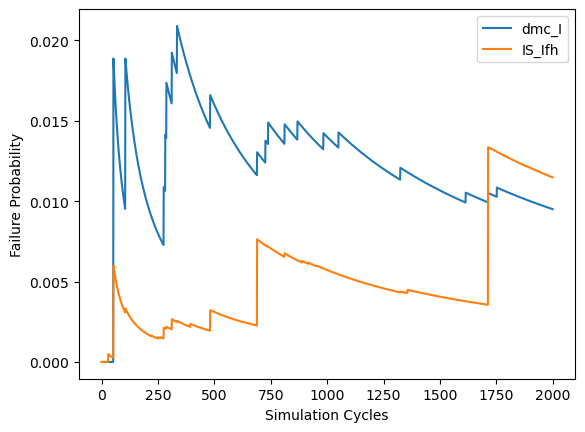

In [11]:
(simVals[['dmc_I', 'IS_Ifh']].expanding().mean()).plot(
  xlabel='Simulation Cycles',
  ylabel='Failure Probability'
)

<Axes: xlabel='Mean value of X_3', ylabel='Failure Probability'>

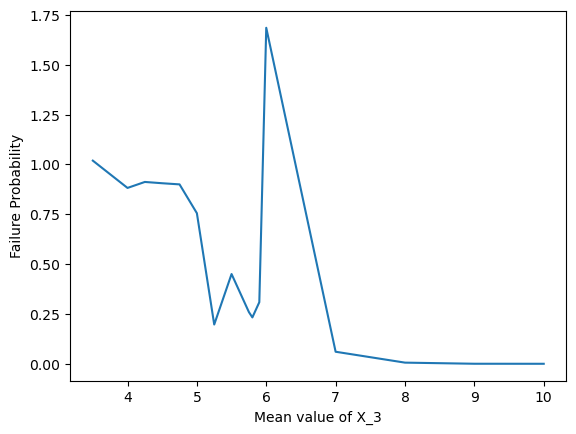

In [12]:
m_vals = [3.5, 4, 4.25, 4.5, 4.75, 5, 5.25, 5.5, 5.75, 5.8, 5.9, 6, 7, 8, 9, 10]
for m in m_vals:
  h = norm(loc=m, scale=XVals.loc[X[3], 'std_dev'])
  simVals[f'IS_x3_m{m}'] = h.rvs(size=2000)
  simVals[f'IS_Z{m}'] = Z_fn(simVals[X[1]], simVals[X[2]], simVals[f'IS_x3_m{m}'])
  simVals[f'IS_I{m}'] = (simVals[f'IS_Z{m}'] < 0).astype(int)
  simVals[f'IS_Ifh{m}'] = simVals[[f'IS_x3_m{m}', f'IS_I{m}']].apply(
    lambda r : XVals.loc[X[3], 'norm_dist'].pdf(r[f'IS_x3_m{m}']) / h.pdf(r[f'IS_x3_m{m}']) if r[f'IS_I{m}'] == 1 else 0,
    axis=1
  )

fig, ax = plt.subplots()
ax.plot(m_vals, simVals[[ f'IS_Ifh{m}' for m in m_vals]].mean() /.009068)
ax.set_xlabel('Mean value of X_3')
ax.set_ylabel('Failure Probability')
ax

<Axes: xlabel='Simulation Cycles', ylabel='Failure Probability'>

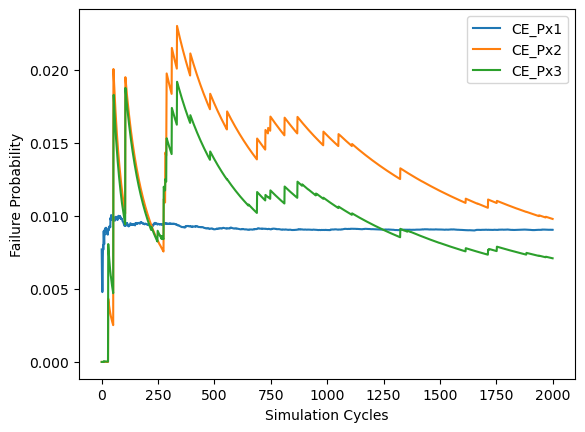

In [13]:
simVals[['CE_Px1','CE_Px2','CE_Px3']].expanding().mean().plot(xlabel='Simulation Cycles', ylabel='Failure Probability')

# Example 4.3 Time-Dependent Reliability Assessment with Corrosion

t                               0         1                             2  \
val         u         s         F         F         p         R         F   
0    0.376518  5.842681  0.967312  0.952283  0.040203  0.960595  0.932166   
1    0.464271  5.955160  0.974718  0.962175  0.031553  0.968939  0.944962   
2    0.448521  5.935301  0.973523  0.960562  0.032958  0.967580  0.942853   
3    0.472658  5.965705  0.975334  0.963010  0.030828  0.969642  0.946056   
4    0.505367  6.006727  0.977611  0.966114  0.028137  0.972255  0.950151   
5    0.428679  5.910131  0.971942  0.958437  0.034811  0.965788  0.940089   
6    0.339809  5.793508  0.963554  0.947352  0.044547  0.956431  0.925897   
7    0.844216  6.505969  0.993894  0.989578  0.008264  0.991770  0.982811   
8    0.740141  6.321890  0.989881  0.983506  0.013307  0.986782  0.973966   
9    0.949507  6.820046  0.997599  0.995544  0.003428  0.996578  0.992042   

t                               3                      
val         p         R         F         p         R  
0    0.048989  0.906669  0.906054  0.059623  0.836216  
1    0.038992  0.924978  0.922079  0.048155  0.865486  
2    0.040625  0.921963  0.919411  0.050039  0.860606  
3    0.038148  0.926543  0.923468  0.047178  0.868026  
4    0.035002  0.932390  0.928692  0.043528  0.877584  
5    0.042774  0.918009  0.915932  0.052512  0.854245  
6    0.053961  0.897697  0.898330  0.065270  0.822169  
7    0.011035  0.978172  0.972598  0.014788  0.956605  
8    0.017285  0.966020  0.960192  0.022497  0.934736  
9    0.004817  0.990411  0.986316  0.006819  0.979752

t,1,2,3,4,5,6,7,8,9,10
a,,,,,,,,,,
0.00,0.963163,0.929117,0.897554,0.868203,0.840835,0.815248,0.791266,0.768735,0.747522,0.727508
0.01,0.961112,0.921265,0.880550,0.839070,0.796937,0.754281,0.711243,0.667983,0.624676,0.581513
0.02,0.958870,0.912348,0.860432,0.803316,0.741439,0.675512,0.606536,0.535792,0.464800,0.395237
0.03,0.956425,0.902277,0.836915,0.760491,0.674232,0.580625,0.483398,0.387203,0.296982,0.217133
0.05,0.950880,0.878349,0.779102,0.654673,0.513592,0.370858,0.243564,0.144367,0.077082,0.037262
0.10,0.932689,0.794838,0.583524,0.351787,0.173027,0.072655,0.027938,0.010386,0.003828,0.001408


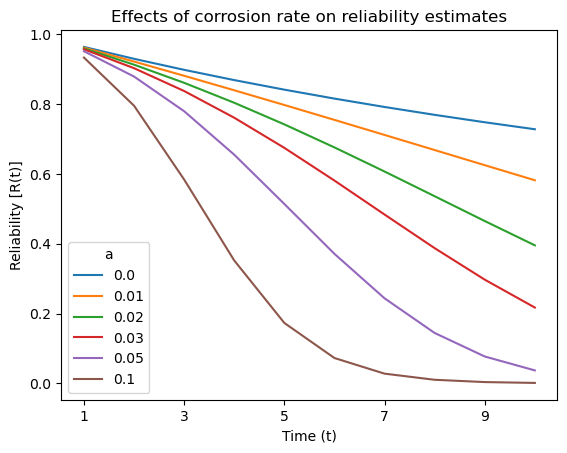

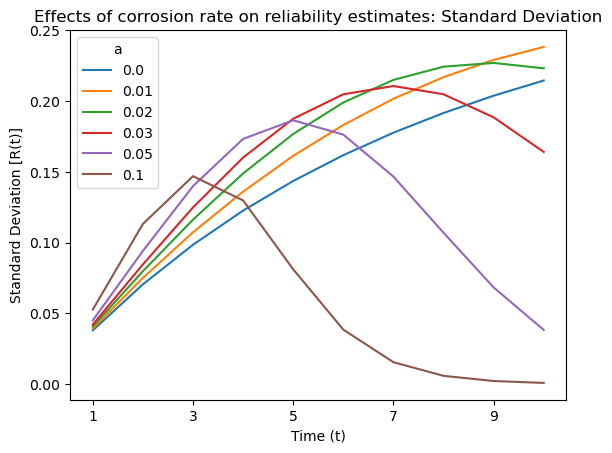

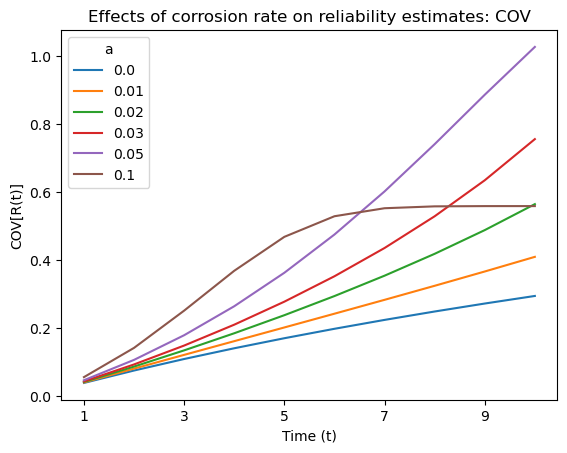

In [14]:
c = lambda a,b,t : 1- a * t ** b
lambd = 1
N = 200
T = 10
S_dist = norm(loc=6, scale=.5)
L_dist = norm(loc=4, scale=1)
corrosionVal = pd.DataFrame([
  0.376518,
  0.464271,
  0.448521,
  0.472658,
  0.505367,
  0.428679,
  0.339809,
  0.844216,
  0.740141,
  0.949507,
  *np.random.random_sample(N - 10)
], columns=pd.MultiIndex.from_tuples([('', 'u')], names=['t', 'val']))
corrosionVal[('', 's')] = corrosionVal[('', 'u')].apply(S_dist.ppf)
b = 1

corrosionRates = []
aList = [ 0, 0.01, 0.02 ,0.03, 0.05, 0.10]
for a in aList:
  corrosionValA = corrosionVal.copy()
  for t in range(T + 1):
    corrosionValA[(t,'F')] = corrosionValA[('', 's')].apply(lambda s : L_dist.cdf(c(a,b,t) * s))
    if t <= 0: continue
    previousArea = corrosionValA[(t-1,'area')] if t > 1 else 0
    corrosionValA[(t,'area')] = (corrosionValA[(t,'F')] + corrosionValA[(t-1,'F')]) / 2 + previousArea
    corrosionValA[(t,'p')] = 1 - corrosionValA[(t,'area')] / t
    corrosionValA[(t,'R')] = np.exp(- lambd * t * corrosionValA[(t,'p')])

    if t == 3 and a == 0.03:
      display(corrosionValA[[( '','u'),( '','s'),( 0,'F'), (1,'F'),(1,'p'), ( 1,'R'), (2,'F'),(2,'p'), ( 2,'R'), (3,'F'),(3,'p'), (3,'R')]].head(10))
  corrosionValA.columns = pd.MultiIndex.from_tuples(corrosionValA.columns, names=['t', 'val'])

  corrosionRates.append(corrosionValA)
corrosionRatesDf = pd.concat(corrosionRates, axis=0, keys =aList, names=['a','i'])

resultsDf = corrosionRatesDf.xs('R', axis=1, level=1)

meanPlotDf = resultsDf.groupby('a').mean()

meanPlotDf.T.plot(
  title='Effects of corrosion rate on reliability estimates',
  ylabel='Reliability [R(t)]',
  xlabel='Time (t)'
)
display(meanPlotDf)

covPlotDf = np.sqrt(resultsDf.groupby('a').var())

covPlotDf.T.plot(
  title='Effects of corrosion rate on reliability estimates: Standard Deviation',
  ylabel='Standard Deviation [R(t)]',
  xlabel='Time (t)'
);

(covPlotDf/meanPlotDf).T.plot(
  title='Effects of corrosion rate on reliability estimates: COV',
  ylabel='COV[R(t)]',
  xlabel='Time (t)'
);